In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 1):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

In [2]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms as T

class PennFudanDataset(Dataset):

    def __init__(self, root):
        self.root = root
        # Load image files, sorting for alignment.
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

        # Define transforms: Resize to (128, 128) and ToTensor
        self.transforms = T.Compose([
            T.Resize((256, 256), antialias=True),  # Resize both image and mask
            T.PILToTensor(),  # Convert PIL Image to Tensor
            T.ConvertImageDtype(torch.float),  # Normalize to [0, 1]
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.mask_transform = T.Compose([
          T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
          T.PILToTensor()
        ])


    def __getitem__(self, idx):
        # Load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)


        # Combine instance masks into a single binary mask.
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)
        mask = Image.fromarray(mask) # convert back to PIL to apply transform

        # Apply transforms
        img = self.transforms(img)

        mask = self.mask_transform(mask)
        mask = mask.to(torch.uint8)  # Ensure correct dtype
        mask = mask.squeeze(0)

        return img, mask

    def __len__(self):
        return len(self.imgs)

dataset_root = "data/PennFudanPed"  # Replace with your actual path
dataset = PennFudanDataset(dataset_root)

In [3]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Epoch 0, Batch 0, Loss 0.6713
Epoch 0, Batch 1, Loss 0.6224
Epoch 0, Batch 2, Loss 23.3586
Epoch 0, Batch 3, Loss 0.5831
Epoch 0, Batch 4, Loss 0.6236
Epoch 0, Batch 5, Loss 0.6295
Epoch 1, Batch 0, Loss 0.6360
Epoch 1, Batch 1, Loss 0.6402
Epoch 1, Batch 2, Loss 0.6338
Epoch 1, Batch 3, Loss 0.6371
Epoch 1, Batch 4, Loss 0.6342
Epoch 1, Batch 5, Loss 0.6250
Epoch 2, Batch 0, Loss 0.6166
Epoch 2, Batch 1, Loss 0.6007
Epoch 2, Batch 2, Loss 0.5722
Epoch 2, Batch 3, Loss 0.5684
Epoch 2, Batch 4, Loss 0.5374
Epoch 2, Batch 5, Loss 0.5053
Epoch 3, Batch 0, Loss 0.5174
Epoch 3, Batch 1, Loss 0.5403
Epoch 3, Batch 2, Loss 0.5328
Epoch 3, Batch 3, Loss 0.4945
Epoch 3, Batch 4, Loss 0.4957
Epoch 3, Batch 5, Loss 0.4482
Epoch 4, Batch 0, Loss 0.5093
Epoch 4, Batch 1, Loss 0.4730
Epoch 4, Batch 2, Loss 0.4984
Epoch 4, Batch 3, Loss 0.4455
Epoch 4, Batch 4, Loss 0.5368
Epoch 4, Batch 5, Loss 0.4402
Epoch 5, Batch 0, Loss 0.4894
Epoch 5, Batch 1, Loss 0.4434
Epoch 5, Batch 2, Loss 0.4306
Epoch 5, 

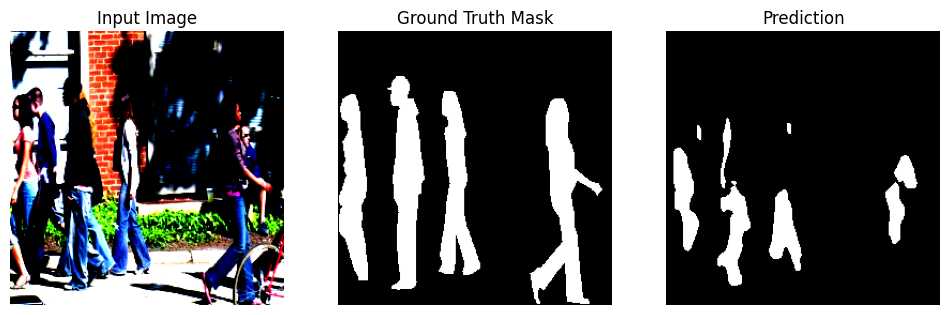

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()
model.train()

for epoch in range(50):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, Batch {batch_idx}, Loss {loss.item():.4f}")

# --- Plotting an Example ---
model.eval()


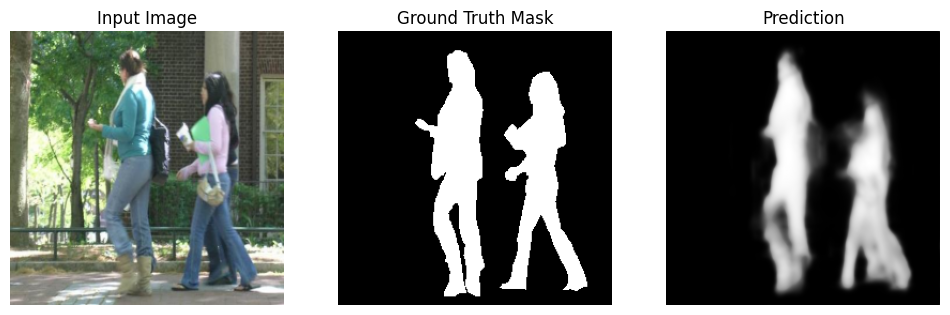

In [11]:
with torch.no_grad():
    data, targets = next(iter(train_loader))
    data, targets = data.to(device), targets.to(device)
    predictions = model(data)
    predictions = torch.sigmoid(predictions)
    img = data[0].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC for matplotlib
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Un-normalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    mask = targets[0].cpu().numpy().squeeze()  # Remove channel dimension
    pred = predictions[0].cpu().numpy().squeeze()  # Remove channel dimension

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    plt.show()

In [10]:
torch.save(model.state_dict(), "unet.pt")